In [3]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, Flatten, Dense
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [5]:
data = np.load('simple_600K_disc0.99_cleaned.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((594333, 11, 11, 18), (594333,), (594333,))

In [6]:
data = np.load('valid_100K_disc0.99_cleaned.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((95623, 11, 11, 18), (95623,), (95623,))

In [7]:
c = x = Input(shape=(11,11,18))
c = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(c)
h = Flatten()(c)
h = Dense(128, activation='relu')(h)
p = Dense(6, activation="softmax", name='p')(h)
h = Dense(128, activation='relu')(h)
v = Dense(1, activation="tanh", name='v')(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 10], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 32)   5216        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 11, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 11, 11, 32)   9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [8]:
history = model.fit(x_train, [p_train, v_train], batch_size=128, epochs=10, validation_data=(x_test, [p_test, v_test]))

Train on 594333 samples, validate on 95623 samples
Epoch 1/10
594333/594333 [==============================] - 56s 94us/step - loss: 2.3367 - p_loss: 1.2332 - v_loss: 0.1104 - p_acc: 0.4555 - val_loss: 2.9199 - val_p_loss: 1.0165 - val_v_loss: 0.1903 - val_p_acc: 0.5383
Epoch 2/10
594333/594333 [==============================] - 54s 91us/step - loss: 1.4370 - p_loss: 0.8957 - v_loss: 0.0541 - p_acc: 0.5908 - val_loss: 2.8322 - val_p_loss: 0.8544 - val_v_loss: 0.1978 - val_p_acc: 0.6050
Epoch 3/10
594333/594333 [==============================] - 54s 91us/step - loss: 1.1834 - p_loss: 0.8072 - v_loss: 0.0376 - p_acc: 0.6240 - val_loss: 2.8397 - val_p_loss: 0.8100 - val_v_loss: 0.2030 - val_p_acc: 0.6213
Epoch 4/10
594333/594333 [==============================] - 54s 90us/step - loss: 1.0812 - p_loss: 0.7709 - v_loss: 0.0310 - p_acc: 0.6354 - val_loss: 2.8131 - val_p_loss: 0.8182 - val_v_loss: 0.1995 - val_p_acc: 0.6202
Epoch 5/10
594333/594333 [==============================] - 54s 91us/

Text(0.5,1,'Value MSE')

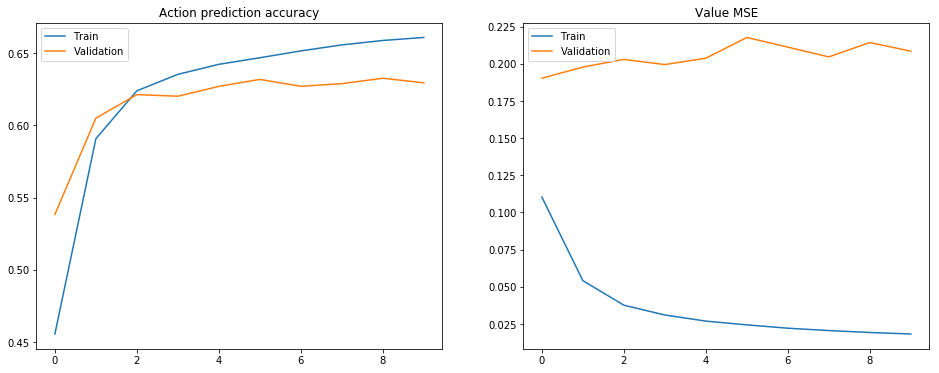

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [10]:
_, v_train_pred = model.predict(x_train)
_, v_test_pred = model.predict(x_test)
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Explained variance train: 0.8827217127612729
Explained variance test: -0.39105035571504


In [11]:
model.save('conv.h5')